In [1]:
import os
import numpy as np
from PIL import Image , ImageOps
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import h5py


import keras
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from pylab import rcParams
import json
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

%matplotlib inline
np.random.seed(123)

Using TensorFlow backend.


In [2]:
def diagnosis (file = 'plasmodium-phone-0005.jpg',path = '../data pre processing/raw data/', weights = './model_weights.h5',num_classes = 2,img_rows = 40, img_cols = 40,step = 15,square_size = 40,image_threshold = 120, threshold = 0.95, show_important_boxes = True, show_all_boxes = True, show_croped_boxes = True, save_log_json = True, global_json_file = 'all_data_summarized' , results_path = './results/'):
    
    #Load model
    input_shape = (img_rows, img_cols, 1)
    
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    


    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

    model.load_weights(weights)

    # Load image to select important areas
    img = Image.open(path+file)
    img2 = mpimg.pil_to_array(img.convert('LA'))
    imag = img2[:,:,0]
    imag[imag>image_threshold] = 255
    imag[imag<=image_threshold] = 0

    interesting_boxes= []

    for i in range(0,imag.shape[0],step):
        for r in range(0,imag.shape[1],step):
            mean = imag[i:i+square_size,r:r+square_size].reshape(1,imag[i:i+square_size,r:r+square_size].shape[0]*imag[i:i+square_size,r:r+square_size].shape[1]).mean(axis=1)
            if mean < 255:
                
                # I inverted r and i to avoid loading the image like
                # imag = np.array(ImageOps.mirror(Image.open('../data pre processing/raw data/'+file[:-4]+'.jpg')).rotate(90))

                interesting_boxes.append([r,i])            
              
    # plot interesting boxes 
    from pylab import rcParams
    if show_important_boxes == True:
        rcParams['figure.figsize'] = 10,50
        print('amount of squares: ',len(interesting_boxes))
        fig,ax = plt.subplots(1)
        ax.imshow(img)
        for i in interesting_boxes:
            #print(max_min[i]['xmax'])    
            rect = patches.Rectangle((i[0],i[1]),
                                    square_size,
                                    square_size,
                                    linewidth=1,edgecolor='g',facecolor='none')
            # Add the patch to the Axes
            ax.add_patch(rect)  
        plt.xticks(())
        plt.yticks(())
        plt.show()

    # Use model in boxes
    croped_images =[]
    boxes = []
    X = []
    rcParams['figure.figsize'] = 1,10

    for box in interesting_boxes:
        crop_img = img.crop((box[0],box[1],box[0]+square_size,box[1]+square_size))
        public_img = crop_img
        if crop_img.size[0] == 40 and crop_img.size[1] == 40:
            crop_img = mpimg.pil_to_array(crop_img)[:,:,0].reshape(1,40,40,-1)/255
            prediction = model.predict(crop_img)
            if prediction[0][1] >= threshold:
                if show_croped_boxes == True:
                    print(prediction)
                    print('prediction', prediction[0][1])
                    plt.imshow(public_img)
                    plt.xticks(())
                    plt.yticks(())
                    plt.show()
                boxes.append([box[0],box[1],prediction[0][1]])
                X.append([box[0],box[1]])

    # Plot all boxes with malaria
    if show_all_boxes == True:
        rcParams['figure.figsize'] = 10,50
        fig,ax = plt.subplots(1)
        ax.imshow(img)
        for box in boxes:
            #print(max_min[i]['xmax'])    
            if box[2]>=0.5 :
                rect = patches.Rectangle((box[0],box[1]),
                                        square_size,
                                        square_size,
                                        linewidth=1,edgecolor='g', alpha=0.5)
                ax.add_patch(rect)  
                plt.xticks(())
                plt.yticks(())
        plt.show()

    # clustering to determine only one box per parasite # used this kluster model http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
    if len(X)>1:
        af = AffinityPropagation(preference=-500).fit(X)
        cluster_centers_indices = af.cluster_centers_indices_
        labels = af.labels_
        selected_boxes = af.cluster_centers_
    else:
        selected_boxes = X

    if len(selected_boxes)>0:
        print('Presence of malaria:',len(selected_boxes),'parasites')
    
    # Plot filan image with one box per parasite
    rcParams['figure.figsize'] = 10,50
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for box in selected_boxes:
        rect = patches.Rectangle((box[0],box[1]),
                                square_size,
                                square_size,
                                linewidth=1,edgecolor='g', alpha=0.5)
        ax.add_patch(rect)  
    plt.xticks(())
    plt.yticks(())    
    plt.show()
    
    # create json with info about the parasites in this image
    if save_log_json == True:
        result_json = file[:-4]
        folder_path = results_path+result_json+'/'
        points = {}
        predicted_info = {}
        test_name = result_json
        sample_date ='today'
        sample_location = 'location'
        device_used = 'device'
        sample_diagnosis = 'infected'
        num_points = len(selected_boxes)

        #Create folder it if doesn't exist
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        
        # Save previous figure
        fig.savefig(folder_path+file[:-4]+'.png',dpi=231, bbox_inches='tight')
        
        sample_info = {'name' : test_name, 
                       'date' : sample_date, 
                       'diagnosis': sample_diagnosis, 
                       'num_points':num_points,
                       'location' : sample_location, 
                       'device' : device_used }
        
        point_counter = 0
        for i in selected_boxes:
            point_counter += 1
            index = 'point '+str(point_counter) 
            points[index] =  {'illness':'N/D',
                                'xmin':int(box[0]),
                                'ymin':int(box[1]),
                                'xmax':int(box[0]+40),
                                'ymax':int(box[1]+40)
                                }

        predicted_info = {'info' : sample_info , 'detected_points' : points }

        # Save diccionary as Json

        
        with open(folder_path+result_json+'.json', 'w') as sample_json_data:
            json.dump(predicted_info, sample_json_data)
        
        # Update global json with info about this 
        # First create file if it doesn't exist
        
        try:
            file = open(results_path+global_json_file+'.json', 'r')
        except IOError:
            with open(results_path+global_json_file+'.json', 'w') as sample_json_data:
                empty = {}
                empty['start'] = {'start':'start'}
                json.dump(empty, sample_json_data)
            
        # open and update
        
        with open(results_path+global_json_file+'.json', 'r') as json_data:
            updated_json_data = json.load(json_data)
                
        updated_json_data[test_name] = {'name' : test_name, 
                                       'date' : sample_date, 
                                       'diagnosis': sample_diagnosis, 
                                       'num_points':num_points,
                                       'location' : sample_location, 
                                       'device' : device_used }

        with open(results_path+global_json_file+'.json', 'w') as jsonFile:
           json.dump(updated_json_data, jsonFile)

amount of squares:  999


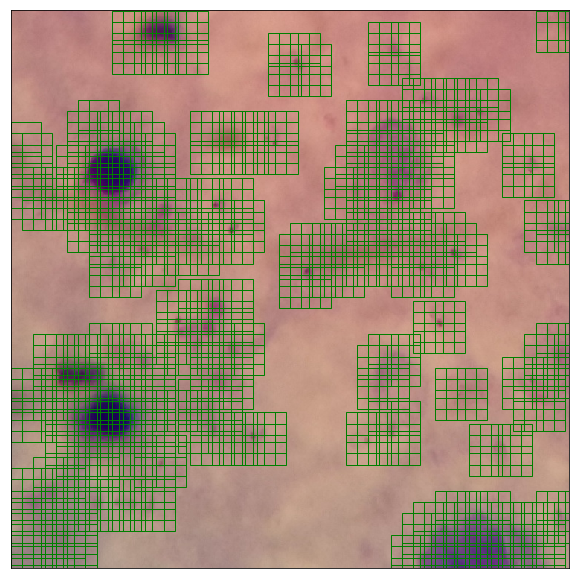

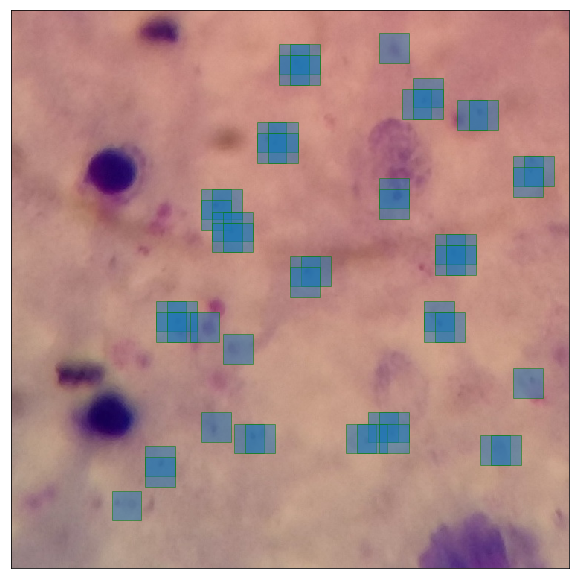

Presence of malaria: 22 parasites


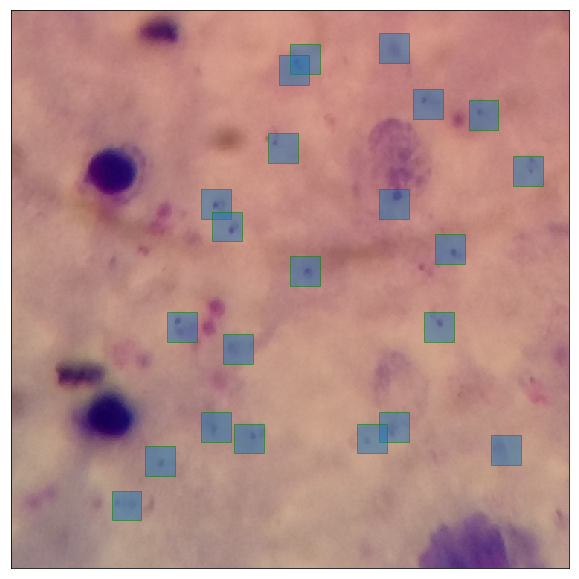

In [8]:
diagnosis (file = 'plasmodium-phone-0002.jpg' , path = '../data pre processing/raw data/' , 
           weights = './model_weights.h5' , num_classes = 2 , img_rows = 40 , img_cols = 40 , step = 15 ,
           square_size = 40 , image_threshold = 130 , threshold = 0.7 , show_important_boxes = True , 
           show_all_boxes = True , show_croped_boxes = False, save_log_json = True , 
           global_json_file = 'all_data_summarized' , results_path = './results/')